In [1]:
from pathlib import Path
import pandas as pd
from data import read_data
import numpy as np
import torch

paired_brain, paired_blood, _, unpaired_blood = read_data(numpy=True)
print(paired_brain.shape, paired_blood.shape, unpaired_blood.shape)

file_path = Path('./logs')
fake_brain = torch.load(file_path / 'fake_brain_3900.pt').detach().cpu().numpy()
fake_blood = torch.load(file_path / 'fake_blood_3900.pt').detach().cpu().numpy()
fake_brain_unpaired = torch.load(file_path / 'fake_brain_unpaired_3900.pt').detach().cpu().numpy()
print(fake_brain.shape, fake_blood.shape, fake_brain_unpaired.shape)


(347, 47) (347, 47) (9462, 47)
(347, 47) (347, 47) (9462, 47)


In [2]:
# import pca
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

data_cat_paired = np.concatenate([paired_brain, paired_blood], axis=0)
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(data_cat_paired)

# normalize data
data_cat_paired_transformed = scaler.transform(data_cat_paired)

data_cat_fake = np.concatenate([fake_brain, fake_blood], axis=0)
data_cat_fake_transformed = scaler.transform(data_cat_fake)

pca = PCA(n_components=2)
pca.fit(data_cat_paired_transformed)

data_cat_pca = pca.transform(data_cat_paired_transformed)
data_cat_fake_pca = pca.transform(data_cat_fake_transformed)



# 08/09 Epigenetic meeting

## Initial training of Cycle-GAN
- training data: 9,463 blood, 2,546 brain (47 features)
- Evaluation data:  348 blood-brain paired data (47 features)
- Generator and discriminator are simple MLPs (3 layers)

## Qualitative evaluation (first 2 components of PCA)
- blood-brain paired data: 348
- they should be exactly matched in the PCA plot in ideal case

## Next steps
- Tune the hyperparameters of Cycle-GAN
- Age prediction using the generated unpaired data (as Dr. Wang mentioned)
  - True blood -> **fake brain**(age?) 
 

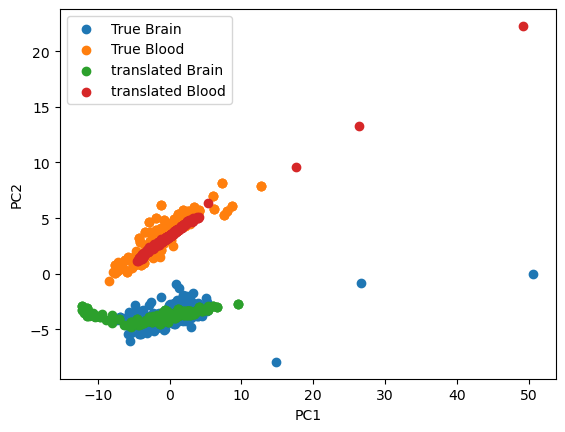

In [3]:
plt.figure()
plt.scatter(data_cat_pca[:paired_blood.shape[0], 0], data_cat_pca[:paired_blood.shape[0], 1], label='True Brain')
plt.scatter(data_cat_pca[paired_blood.shape[0]:, 0], data_cat_pca[paired_blood.shape[0]:, 1], label='True Blood')
plt.scatter(data_cat_fake_pca[:fake_blood.shape[0], 0], data_cat_fake_pca[:fake_blood.shape[0], 1], label='translated Brain')
plt.scatter(data_cat_fake_pca[fake_blood.shape[0]:, 0], data_cat_fake_pca[fake_blood.shape[0]:, 1], label='translated Blood')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Age prediction

In [4]:
_, _, pd_unpaired_brain, pd_unpaired_blood = read_data(numpy=False)
ages = pd.read_csv('./data/all.brain.age.csv')

na_mask = ages['V3'].isna()
ages_clean = ages[~na_mask]

ag_mask = ages_clean['V3'] == '90+'
ages_clean = ages_clean[~ag_mask]

ug_mask = ages_clean['V3'] == 'Unknown'
ages_clean = ages_clean[~ug_mask]

# ng_mask = ages_clean['V3'].to_numpy().astype(float) > 0
# ages_clean = ages_clean[ng_mask] 

age_mask = pd_unpaired_brain.index.isin(ages_clean['V2'])
pd_unpaired_brain = pd_unpaired_brain[age_mask]

In [5]:
pd_unpaired_brain

Unnamed: 0,cg01940425,cg09942248,cg12231969,cg20804050,cg02676375,cg26844246,cg02898094,cg05977669,cg12997720,cg20647467,...,cg13848598,cg09661809,cg25400358,cg12493075,cg02456288,cg12220493,cg21057587,cg21876626,cg26709300,cg11634198
GSM3059446,0.137183,0.023384,0.209353,0.058222,0.093433,0.074638,0.121063,0.253524,0.083569,0.234473,...,0.207761,0.056708,0.374029,0.315745,0.166253,0.121083,0.348481,0.367802,0.113668,0.121375
GSM3059519,0.092152,0.016242,0.211625,0.043549,0.097277,0.056549,0.055587,0.237935,0.100409,0.181047,...,0.203873,0.098156,0.384551,0.296199,0.171828,0.105945,0.385907,0.390745,0.177979,0.14547
GSM3059521,0.091626,0.027915,0.182579,0.047874,0.100358,0.065463,0.069979,0.204776,0.070789,0.220541,...,0.186673,0.066123,0.450507,0.269612,0.162635,0.119149,0.392049,0.372312,0.169973,0.129658
GSM3059522,0.088373,0.025868,0.184113,0.0,0.09779,0.074808,0.051343,0.238141,0.079143,0.199843,...,0.192902,0.085891,0.4238,0.23072,0.138757,0.119569,0.407567,0.351485,0.18245,0.122408
GSM3059523,0.100579,0.022387,0.174783,0.044795,0.07674,0.053087,0.083986,0.215252,0.078692,0.197541,...,0.177146,0.067581,0.428549,0.292372,0.187524,0.125234,0.388379,0.406419,0.140627,0.12173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1198810,0.074395,0.019583,0.186467,0.041629,0.184683,0.116174,0.078031,0.26694,0.132676,0.253805,...,0.257482,0.088578,0.497663,0.132998,0.120137,0.049298,0.24579,0.178191,0.254744,0.145866
GSM1198811,0.066503,0.018255,0.216664,0.038399,0.228786,0.094749,0.086527,0.241932,0.1044,0.23306,...,0.308564,0.085573,0.520537,0.123787,0.106933,0.047601,0.223222,0.157765,0.230176,0.16964
GSM1198812,0.090987,0.020991,0.251229,0.106617,0.230395,0.111178,0.081455,0.299678,0.167917,0.249992,...,0.290127,0.10927,0.539215,0.082824,0.126235,0.059455,0.222966,0.139294,0.276661,0.128202
GSM1198836,0.097069,0.022657,0.19784,0.059658,0.185848,0.094072,0.092657,0.252805,0.111824,0.228602,...,0.19176,0.076392,0.520241,0.122249,0.114198,0.057079,0.243643,0.147035,0.226638,0.140069


In [6]:
# Step 1: Filter ages to get only the matching rows
mask = ages_clean['V2'].isin(pd_unpaired_brain.index)
selected_ages = ages_clean[mask].copy()
selected_ages.loc[:, 'V2_ordered'] = pd.Categorical(selected_ages.loc[:, 'V2'], categories=pd_unpaired_brain.index, ordered=True)
selected_ages_sorted = selected_ages.sort_values('V2_ordered')
selected_ages_sorted = selected_ages_sorted.drop(columns=['V2_ordered'])

print(selected_ages_sorted)


            V1          V2  V3
1    GSE112179  GSM3059446  68
74   GSE112179  GSM3059519  51
76   GSE112179  GSM3059521  43
77   GSE112179  GSM3059522  51
78   GSE112179  GSM3059523  49
..         ...         ...  ..
858   GSE43193  GSM1198810  67
859   GSE43193  GSM1198811  69
860   GSE43193  GSM1198812  73
884   GSE43193  GSM1198836  49
885   GSE43193  GSM1198837  49

[2199 rows x 3 columns]


In [7]:
(selected_ages_sorted['V3'].astype(float).to_numpy() < 0).sum()

99

In [8]:
np_unpaired_brain = pd_unpaired_brain.to_numpy().astype(float)
unpaired_brain_age = selected_ages_sorted['V3'].values.astype(float)

# normalize the data
age_max = unpaired_brain_age.max()
unpaired_brain_age = unpaired_brain_age / age_max

print(np_unpaired_brain.shape, unpaired_brain_age.shape, fake_brain_unpaired.shape)

# train val data split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(np_unpaired_brain, unpaired_brain_age, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# make them torch tensors
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()

X = torch.tensor(fake_brain_unpaired).float()
X_ = torch.tensor(unpaired_blood).float()
print(X.shape, X_.shape)

(2199, 47) (2199,) (9462, 47)
(1759, 47) (440, 47) (1759,) (440,)
torch.Size([9462, 47]) torch.Size([9462, 47])


In [9]:
# set up a simple MLP using pytorch with input shape 47 and output shape 1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class AgePredictor(nn.Module):
    def __init__(self):
        super(AgePredictor, self).__init__()
        self.fc1 = nn.Linear(47, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = AgePredictor()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# train the model
mae_opt = 1000
for epoch in range(2000):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    # if epoch % 100 == 0:
    #     print(f'Epoch {epoch}, Loss {loss.item()}')
        
    # evaluate the model
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            # MAE
            mae = torch.mean(torch.abs((y_pred_val.squeeze() - y_val)*age_max))
            if mae < mae_opt:
                mae_opt = mae
                torch.save(model.state_dict(), './age_predictor.pt')
                best_model = model
                print(f'Epoch {epoch}, Loss {loss.item()}, MAE {mae.item()}')
        model.train()


Epoch 0, Loss 0.3262653648853302, MAE 52.24574279785156
Epoch 10, Loss 0.07103701680898666, MAE 23.378849029541016
Epoch 20, Loss 0.04072608798742294, MAE 19.81182098388672
Epoch 30, Loss 0.02498297020792961, MAE 14.813112258911133
Epoch 40, Loss 0.016099106520414352, MAE 12.081221580505371
Epoch 50, Loss 0.012385590933263302, MAE 10.717535018920898
Epoch 60, Loss 0.009770827367901802, MAE 9.495879173278809
Epoch 70, Loss 0.00811545830219984, MAE 8.549297332763672
Epoch 80, Loss 0.007050762418657541, MAE 7.7591986656188965
Epoch 90, Loss 0.0064272573217749596, MAE 7.360045909881592
Epoch 100, Loss 0.006008782424032688, MAE 7.145273685455322
Epoch 110, Loss 0.005736784543842077, MAE 7.009380340576172
Epoch 120, Loss 0.0055340793915092945, MAE 6.883823394775391
Epoch 130, Loss 0.005384114105254412, MAE 6.804383277893066
Epoch 140, Loss 0.0052618607878685, MAE 6.753135681152344
Epoch 150, Loss 0.005148438271135092, MAE 6.7033162117004395
Epoch 160, Loss 0.0050436751917004585, MAE 6.673515

In [10]:
# model.load_state_dict(torch.load('./age_predictor.pt')) 
pred_age_fake_brain = best_model(X)*age_max
pred_age_unpaired_blood = best_model(X_)*age_max

In [11]:
pred_age_fake_brain = pred_age_fake_brain.detach().cpu().numpy()
pred_age_unpaired_blood = pred_age_unpaired_blood.detach().cpu().numpy()

In [12]:
print(pred_age_fake_brain.shape, pred_age_unpaired_blood.shape)

(9462, 1) (9462, 1)


In [13]:
pd_unpaired_blood.index

Index(['GSM2814580', 'GSM2814581', 'GSM2814582', 'GSM2814583', 'GSM2814584',
       'GSM2814585', 'GSM2814586', 'GSM2814587', 'GSM2814588', 'GSM2814589',
       ...
       'GSM2337342', 'GSM2337343', 'GSM2337344', 'GSM2337346', 'GSM2337267',
       'GSM2337269', 'GSM2337271', 'GSM2337272', 'GSM2337274', 'GSM2337275'],
      dtype='object', length=9462)

In [14]:
# set index name to ID, second column to age
pd.DataFrame(pred_age_fake_brain, index=pd_unpaired_blood.index, columns=['age']).to_csv('fake_brain_age_pred_new2.csv', index_label='ID')

In [15]:
pd.DataFrame(pred_age_unpaired_blood, index=pd_unpaired_blood.index, columns=['age']).to_csv('true_blood_age_pred_direct.csv', index_label='ID')

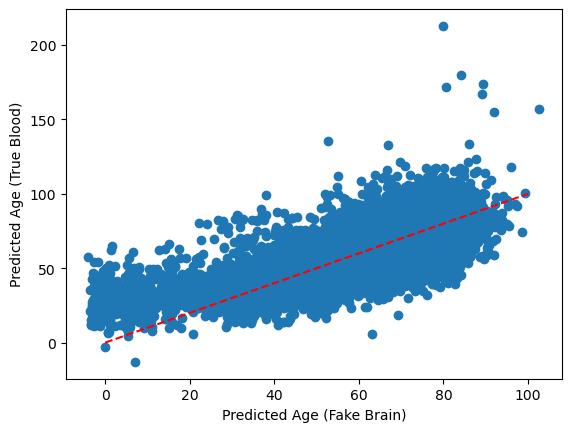

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(pred_age_fake_brain, pred_age_unpaired_blood)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Predicted Age (Fake Brain)')
plt.ylabel('Predicted Age (True Blood)')
plt.savefig('age_pred_fake_brain_vs_true_blood.png')